In [12]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import math
from datetime import datetime, timedelta

Start import
Working on midway2-0411.rcc.local with the following versions 
and installation paths:
strax
	v0.15.3	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.8	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy','abandon','flash',
                                     'ramp down','hev test','_messy'),
                       run_mode='ambe_link',
                       available=('events','peak_basics'))

Checking data availability: 100%|██████████| 3/3 [03:05<00:00, 61.71s/it]


In [4]:
dsets = dsets[(dsets.end > pd.to_datetime('06/03/2021'))]

In [5]:
dsets

name number       mode                     end                   start  \
768  021463  21463  ambe_link 2021-06-05 07:33:05.423 2021-06-05 07:31:31.685   
770  021461  21461  ambe_link 2021-06-05 07:30:39.007 2021-06-05 07:20:58.727   
772  021459  21459  ambe_link 2021-06-05 07:20:13.491 2021-06-05 07:17:59.913   
774  021457  21457  ambe_link 2021-06-05 07:17:39.811 2021-06-05 06:47:38.474   
776  021455  21455  ambe_link 2021-06-05 06:47:22.111 2021-06-05 06:17:20.828   
..      ...    ...        ...                     ...                     ...   
937  021294  21294  ambe_link 2021-06-03 14:50:48.536 2021-06-03 14:20:45.056   
939  021292  21292  ambe_link 2021-06-03 14:20:29.007 2021-06-03 13:50:27.180   
941  021290  21290  ambe_link 2021-06-03 13:50:07.536 2021-06-03 13:20:06.150   
943  021288  21288  ambe_link 2021-06-03 13:19:46.517 2021-06-03 12:49:44.657   
945  021286  21286  ambe_link 2021-06-03 12:48:59.398 2021-06-03 12:23:36.681   

                                                  tags               livetime  \
768                                   _sr0_preliminary 0 days 00:01:33.738000   
770                                   _sr0_preliminary 0 days 00:09:40.280000   
772           _sr0_preliminary,ambe_source_top_ccw5d0m 0 days 00:02:13.578000   
774           _sr0_preliminary,ambe_source_top_ccw5d0m 0 days 00:30:01.337000   
776           _sr0_preliminary,ambe_source_top_ccw5d0m 0 days 00:30:01.283000   
..                                                 ...                    ...   
937  prioritize,_sr0_preliminary,ambe_source_bottom... 0 days 00:30:03.480000   
939  prioritize,_sr0_preliminary,ambe_source_bottom... 0 days 00:30:01.827000   
941  prioritize,_sr0_preliminary,ambe_source_bottom... 0 days 00:30:01.386000   
943  prioritize,_sr0_preliminary,ambe_source_bottom... 0 days 00:30:01.860000   
945                                   _sr0_preliminary 0 days 00:25:22.717000   

     raw_records_available  peak_basics_available  events_available  
768                  False                   True              True  
770                  False                   True              True  
772                  False                   True              True  
774                  False                   True              True  
776                  False                   True              True  
..                     ...                    ...               ...  
937                  False                   True              True  
939                  False                   True              True  
941                  False                   True              True  
943                  False                   True              True  
945                  False                   True              True  

[88 rows x 10 columns]

In [6]:
AmBe_runs = np.array(dsets['name'])

In [7]:
AmBe_runs

array(['021463', '021461', '021459', '021457', '021455', '021453',
       '021451', '021449', '021447', '021445', '021443', '021441',
       '021439', '021437', '021435', '021433', '021431', '021429',
       '021427', '021425', '021423', '021421', '021419', '021417',
       '021415', '021413', '021411', '021409', '021407', '021405',
       '021403', '021401', '021399', '021397', '021395', '021393',
       '021391', '021389', '021387', '021385', '021383', '021381',
       '021379', '021377', '021375', '021373', '021371', '021369',
       '021367', '021365', '021363', '021361', '021359', '021357',
       '021355', '021353', '021349', '021347', '021345', '021343',
       '021341', '021339', '021337', '021335', '021333', '021331',
       '021329', '021327', '021325', '021323', '021320', '021318',
       '021316', '021314', '021312', '021310', '021308', '021306',
       '021304', '021302', '021300', '021298', '021296', '021294',
       '021292', '021290', '021288', '021286'], dtype=object)

run 021300, start 2021-06-03 10:51:51.179859, livetime 1800.38 s, rate: 17.33 Hz, selection rate: 14.10 Hz


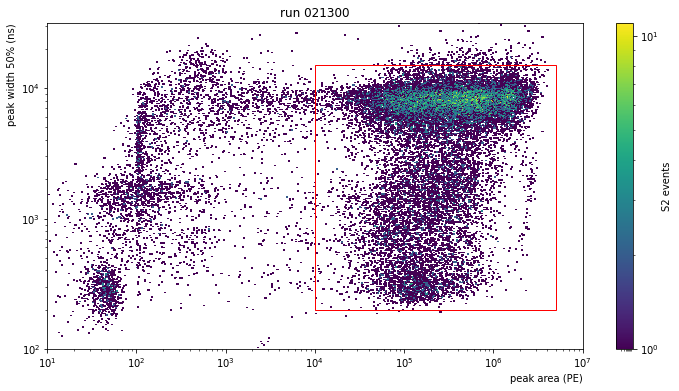

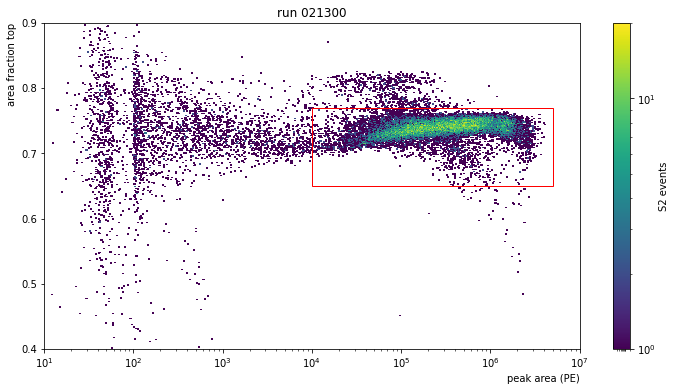

In [34]:
run = AmBe_runs[80]
events = st.get_df(run,'event_info',progress_bar=False)
a = ddu.mask_s2_area_width_aft(events,run,area_cut=(1e4,5e6),width_cut=(200,1.5e4),aft_cut=(0.65,0.77),high=7,plot=1)

In [35]:
runs, all_rates, mask_rates, times = [], [], [], []
for run in AmBe_runs:
    events = st.get_df(run,'event_info',progress_bar=False)
    mask, all_rate, mask_rate, start_time = ddu.mask_s2_area_width_aft(events,run,area_cut=(1e4,5e6),width_cut=(200,1.5e4),aft_cut=(0.65,0.77),high=7)
    all_rates = np.append(all_rates,all_rate)
    mask_rates = np.append(mask_rates,mask_rate)
    times = np.append(times,start_time)
    runs = np.append(runs,run)

run 021463, start 2021-06-05 02:31:31.027089, livetime 93.54 s, rate: 6.76 Hz, selection rate: 5.09 Hz
run 021461, start 2021-06-05 02:20:58.096798, livetime 580.09 s, rate: 6.81 Hz, selection rate: 5.10 Hz
run 021459, start 2021-06-05 02:17:59.055440, livetime 133.52 s, rate: 6.85 Hz, selection rate: 5.26 Hz
run 021457, start 2021-06-05 01:47:38.103643, livetime 1801.11 s, rate: 7.05 Hz, selection rate: 5.28 Hz
run 021455, start 2021-06-05 01:17:20.003368, livetime 1800.93 s, rate: 7.14 Hz, selection rate: 5.37 Hz
run 021453, start 2021-06-05 00:47:02.010798, livetime 1801.63 s, rate: 7.17 Hz, selection rate: 5.42 Hz
run 021451, start 2021-06-05 00:16:40.143138, livetime 1801.07 s, rate: 7.08 Hz, selection rate: 5.33 Hz
run 021449, start 2021-06-04 23:46:19.052386, livetime 1800.32 s, rate: 7.18 Hz, selection rate: 5.35 Hz
run 021447, start 2021-06-04 23:16:00.058776, livetime 1801.87 s, rate: 7.07 Hz, selection rate: 5.33 Hz
run 021445, start 2021-06-04 22:45:38.215194, livetime 1801

run 021304, start 2021-06-03 11:52:32.002838, livetime 1803.12 s, rate: 17.19 Hz, selection rate: 13.98 Hz
run 021302, start 2021-06-03 11:22:11.124328, livetime 1800.97 s, rate: 17.28 Hz, selection rate: 14.00 Hz
run 021300, start 2021-06-03 10:51:51.179859, livetime 1800.38 s, rate: 17.33 Hz, selection rate: 14.10 Hz
run 021298, start 2021-06-03 10:21:28.036248, livetime 1802.74 s, rate: 17.46 Hz, selection rate: 14.21 Hz
run 021296, start 2021-06-03 09:51:08.054647, livetime 1800.89 s, rate: 17.12 Hz, selection rate: 13.88 Hz
run 021294, start 2021-06-03 09:20:45, livetime 1803.20 s, rate: 17.37 Hz, selection rate: 14.14 Hz
run 021292, start 2021-06-03 08:50:27.121523, livetime 1801.70 s, rate: 17.34 Hz, selection rate: 14.06 Hz
run 021290, start 2021-06-03 08:20:06.067444, livetime 1801.28 s, rate: 17.23 Hz, selection rate: 14.02 Hz
run 021288, start 2021-06-03 07:49:44.057758, livetime 1801.74 s, rate: 17.24 Hz, selection rate: 14.00 Hz
run 021286, start 2021-06-03 07:23:36.003447

In [36]:
def plot_rate_vs_time(runs,mask_rates,all_rates,times):
    plt.figure(figsize=(12,6))
    dates = matplotlib.dates.date2num(times + timedelta(hours=7))
    plt.plot_date(dates, mask_rates,'o',label='selection rate')
    plt.plot_date(dates, all_rates,'o',label='total rate')
    myFmt = matplotlib.dates.DateFormatter('%d%bH%H')
    plt.gca().xaxis.set_major_formatter(myFmt)
    plt.title(f'runs {runs[-1]} - {runs[0]}')
    plt.xlabel("LNGS time", ha='right', x=1,fontsize=12)
    plt.ylabel("rate (Hz)", ha='right', y=1,fontsize=12)
    plt.legend(fontsize=14)

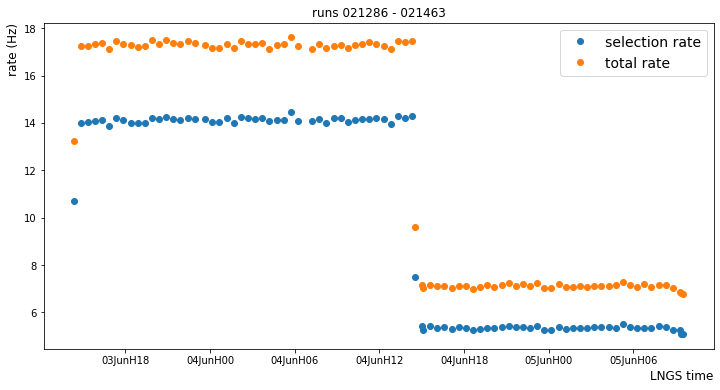

In [37]:
plot_rate_vs_time(runs,mask_rates,all_rates,times)

In [44]:
def diffusion_analysis(run_, vd = 0.677, vd_err = 0.006, area_cut=(1e4,5e6), fit_range=(1,1500), plot = False ):
    run = int(run_)
    events = st.get_df(run_,'event_info',progress_bar=False)
    #if(plot): ddu.plot_area_width_aft(events, run_)
    mask_awt = ddu.mask_s2_area_width_aft(events,run_,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),high=7,plot=plot)
    e1 = events[mask_awt[0]]
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity(e1, run_, low=100,catlim=2000, plot=plot)
    d, d_err, par, par_err = ddu.diffusion_constant(e1,run_,fit_range=(200,1500),vd = vd,plot=plot)
    return run, vd, vd_err, d, d_err, par, par_err

run 021455, start 2021-06-05 01:17:20.003368, livetime 1800.93 s, rate: 7.14 Hz, selection rate: 5.37 Hz
Drift velocity = 0.670~mm/$\mu$s
Diffusion constant = 50.13 +/- inf cm$^2$/s 


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


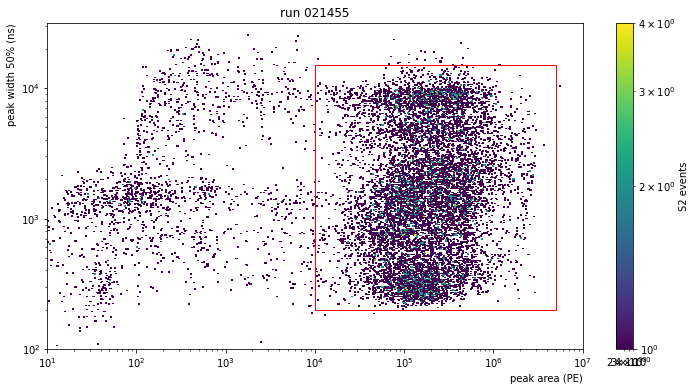

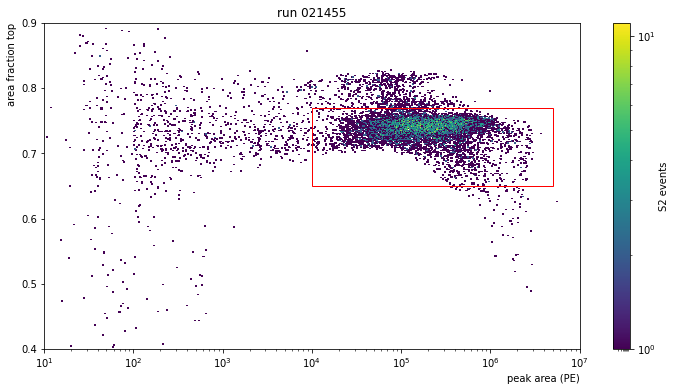

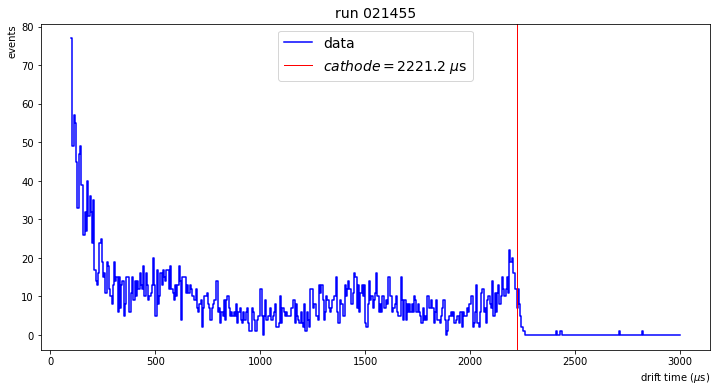

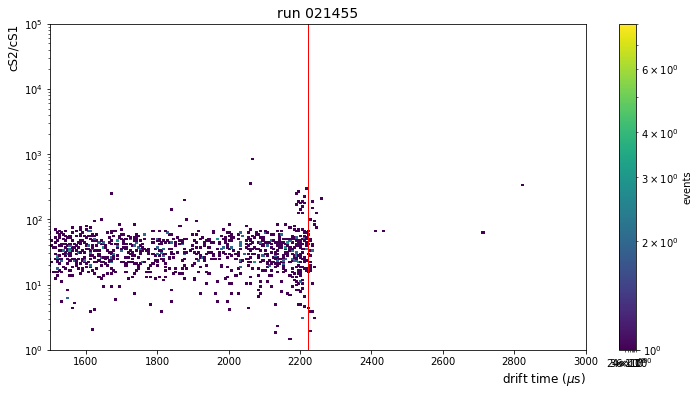

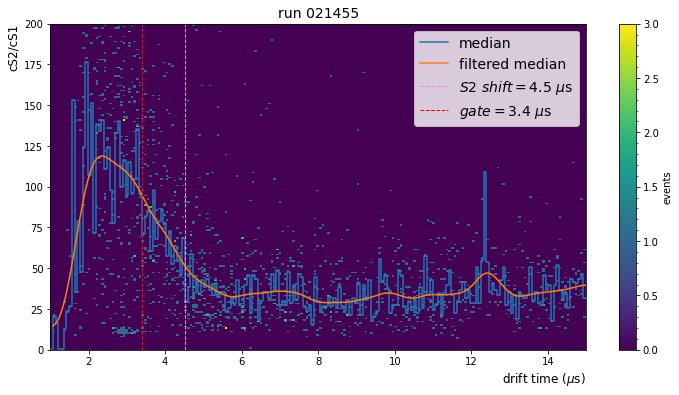

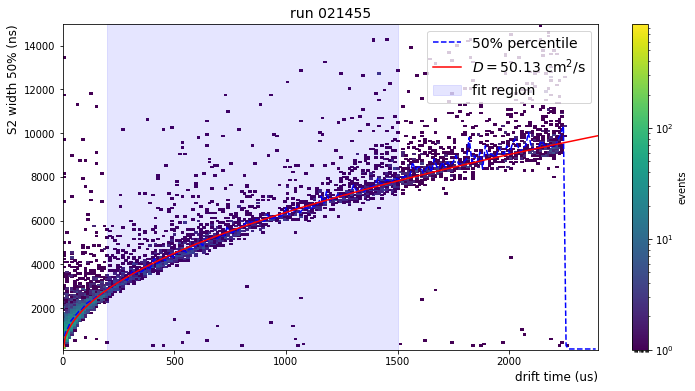

In [45]:
run, vd, vd_err, d, d_err, par, par_err = diffusion_analysis(AmBe_runs[4],area_cut=(1e4,5e6),fit_range=(1,1500), plot = True)

In [46]:
def merge_runs(runs):
    ev0 = st.get_df(runs[0],'event_info',progress_bar=False)
    print('Reading runs from',runs[-1],'to',runs[0])
    start = time.time()
    for i, run_id in enumerate(runs[1:]):
        if ((i+1)%5) == 0: print(f'n. {i} run {run_id} elapsed time: {time.time()-start:.2f} s')
        ev_temp = st.get_df(run_id,'event_info',progress_bar=False)
        frames = [ev0,ev_temp]
        ev0 = pd.concat(frames)
    return ev0

In [47]:
AmBe_events = merge_runs(AmBe_runs)

Reading runs from 021286 to 021463
n. 4 run 021453 elapsed time: 0.69 s
n. 9 run 021443 elapsed time: 1.40 s
n. 14 run 021433 elapsed time: 2.48 s
n. 19 run 021423 elapsed time: 3.58 s
n. 24 run 021413 elapsed time: 5.11 s
n. 29 run 021403 elapsed time: 6.86 s
n. 34 run 021393 elapsed time: 9.11 s
n. 39 run 021383 elapsed time: 11.44 s
n. 44 run 021373 elapsed time: 14.25 s
n. 49 run 021363 elapsed time: 18.59 s
n. 54 run 021353 elapsed time: 23.56 s
n. 59 run 021341 elapsed time: 29.28 s
n. 64 run 021331 elapsed time: 35.68 s
n. 69 run 021320 elapsed time: 43.01 s
n. 74 run 021310 elapsed time: 51.13 s
n. 79 run 021300 elapsed time: 60.77 s
n. 84 run 021290 elapsed time: 70.50 s


In [91]:
from scipy.stats import beta, chi2
from scipy.interpolate import interp1d
def basic_cuts(data, aft_cut = True, lim_rad = 70):
    cut = np.ones(len(data), dtype=bool)
    cut &= data['drift_time'] > 2.0e3
    cut &= data['s2_area'] > 100
    cut &= data['z'] > -144
    cut &= data['r'] < lim_rad
    cut_basics = np.ones(len(data), dtype=bool)
    cut_basics[:] = cut.copy()
    cut &= data['z'] < -2
    cut &= data['s1_area_fraction_top'] < 0.6 # conservative
    cut &= data['alt_s2_area'] < np.clip(data['s2_area']*0.005, 80, np.inf)
    # cut on S2 AFT
    mu = 0.725
    a = np.logspace(2, 6.5, 201)
    _a = np.clip(a, 0, 1e3)
    b = beta.isf(0.0001, ((_a * mu) / 1.2).astype(int),((_a - _a * mu) / 1.2).astype(int))
    c = beta.isf(0.9999, ((_a * mu) / 1.2).astype(int),((_a - _a * mu) / 1.2).astype(int))
    aft_ul = interp1d(a, b, bounds_error=False, fill_value='extrapolate')
    aft_ll = interp1d(a, c, bounds_error=False, fill_value='extrapolate')
    if aft_cut:
        cut &= data['s2_area_fraction_top'] < aft_ul(data['s2_area'])
        cut &= data['s2_area_fraction_top'] > aft_ll(data['s2_area'])
    # cut on S2 width
    b = chi2.isf(0.1, _a / 40) / (_a / 40)
    c = chi2.isf(0.9, _a / 40) / (_a / 40)
    s2w_ul = interp1d(a, b, bounds_error=False, fill_value='extrapolate')
    s2w_ll = interp1d(a, c, bounds_error=False, fill_value='extrapolate')
    #if width_cut:
    #    cut &= data['s2_range_50p_area'] < s2w_ul(data['s2_area'])
    #    cut &= data['s2_range_50p_area'] > s2w_ll(data['s2_area'])
    return cut

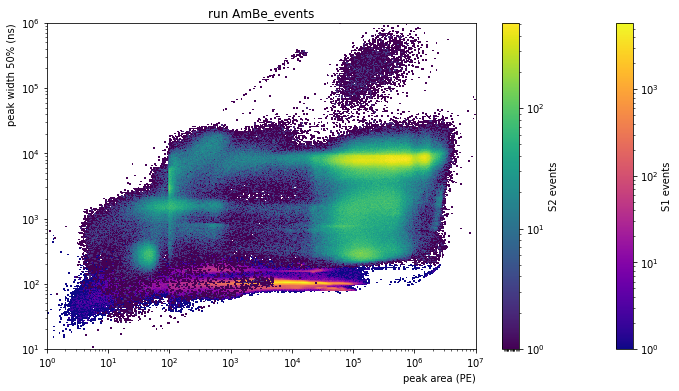

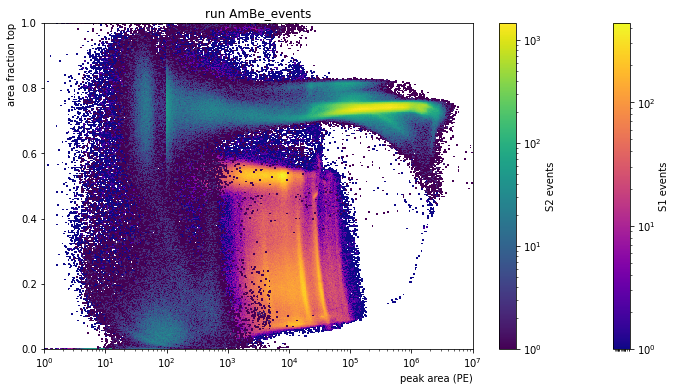

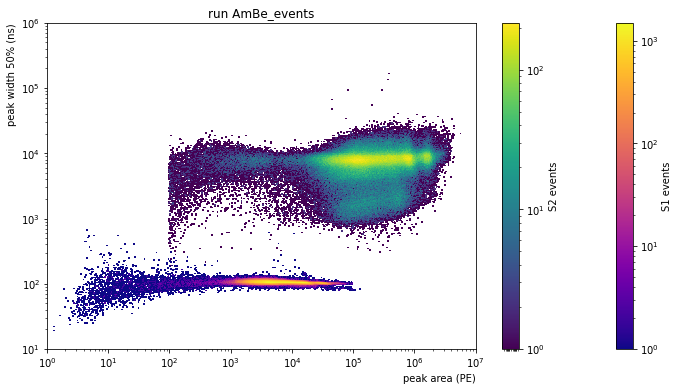

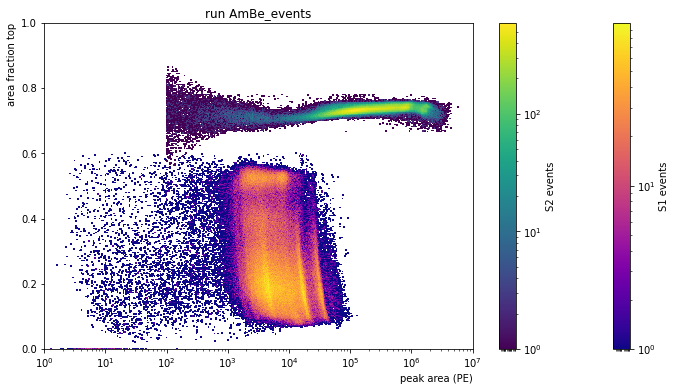

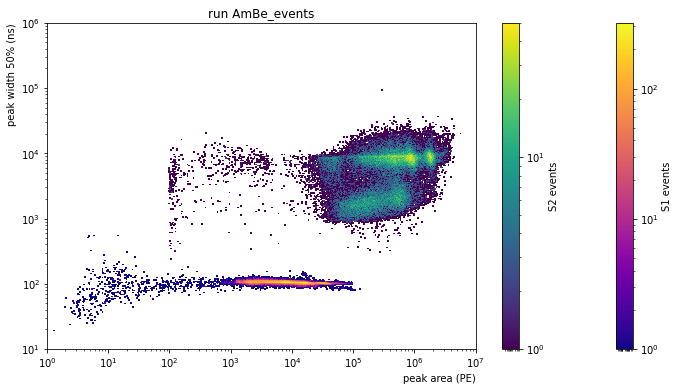

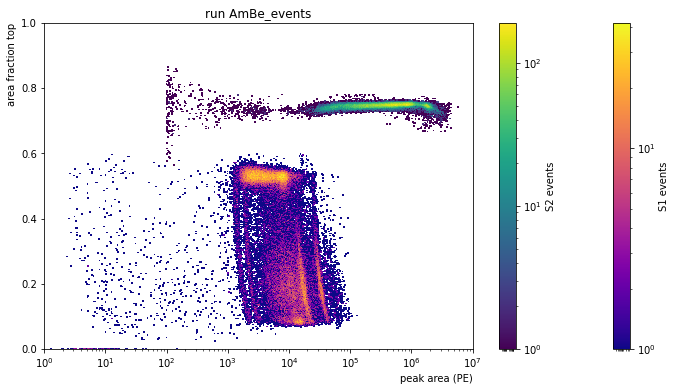

In [94]:
ddu.plot_area_width_aft(AmBe_events,'AmBe_events', low = 0, high = 7, low2 = 0, high2 = 1, binning = 500)
ddu.plot_area_width_aft(AmBe_events[basic_cuts(AmBe_events)],'AmBe_events', low = 0, high = 7, low2 = 0, high2 = 1, binning = 500)
ddu.plot_area_width_aft(AmBe_events[basic_cuts(AmBe_events,lim_rad=55)],'AmBe_events', low = 0, high = 7, low2 = 0, high2 = 1, binning = 500)

In [97]:
def S2WidthCut_percentile(ev0, runs, mod_par = (45, 0.675, 350), wrange = (500,15000), lim_rad = 70,
                          fit_range = (200,1500), perc = (10,80) ):
    events = ev0[basic_cuts(ev0,lim_rad=lim_rad)]
    s2width = events['s2_range_50p_area']
    drift = events['drift_time']/1e3
    s2area = events['s2_area']
    
    print('total events',len(ev0),'selected events',len(events))
    
    t = np.linspace(0, 2400, 200)
    wspace = np.linspace(wrange[0], wrange[1], 200)
    ph = Histdd(drift, s2width, bins=(t, wspace))
    
    # fit 50 percentile
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    D_mod = mod_par[0]*1e3 * units.cm**2 / units.s
    vd_mod = mod_par[1] * units.mm / units.us
    w0_mod = mod_par[2] * units.ns
    guess = np.array([D_mod, vd_mod, w0_mod])
    ll = np.where(t>fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: ddu.diffusion_model(x, D, vd, w0)
    par, pcov = curve_fit(diffusion, t[ll:hh], perc50[ll:hh], p0=(D_mod, w0_mod))
    perr = np.sqrt(np.diag(pcov))
    ys = diffusion(t, *par)
    
    ys_mod = ddu.diffusion_model(t, D_mod, vd_mod, w0_mod)
    
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    #plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    #plt.plot((t[1:]+t[:-1])/2, perc50, color='b',linestyle='--', label='50% percentile')
    plt.plot(t, ys, 'r--',label=f'fit: $D = {par[0]/1e2:.2f}$ cm$^2$/s')
    plt.plot(t, ys_mod, 'b--',label=f'model: $D = {mod_par[0]:.2f}$ cm$^2$/s')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run{runs[0]} - {runs[-1]}',fontsize=14)
    plt.legend(fontsize=14)
    
    #plt.figure(figsize=(12,6))
    #ev = events[(s2width > diffusion(drift, *pard)) & (s2width < diffusion(drift, *paru))]
    #phh = Histdd(ev['drift_time']/1e3, ev['s2_range_50p_area'],bins=(t, wspace))
    #phh.plot(log_scale=True, cblabel='events')
    #plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    #plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    #plt.title(f'run{runs[0]} - {runs[-1]}',fontsize=14)
    
    #normalized width using D from fit
    #norm50a = ev['s2_range_50p_area']/diffusion(ev['drift_time']/1e3, *par)
    norm50b = events['s2_range_50p_area']/diffusion(events['drift_time']/1e3, *par)
    aspace = np.logspace(2.5, 7, 200)
    nspace = np.linspace(0, 6, 200)
    #pha = Histdd(ev['s2_area'], norm50a, bins=(aspace, nspace))
    phb = Histdd(events['s2_area'], norm50b, bins=(aspace, nspace))
    plt.figure(figsize=(12,6))
    #pha.plot(log_scale=True, cblabel='events after S2WidthCut',cmap='plasma')
    phb.plot(log_scale=True, cblabel='events')#,alpha=0.2)
    perc90b = np.array(phb.percentile(percentile=99, axis=1))
    perc10b = np.array(phb.percentile(percentile=1, axis=1))
    plt.plot((aspace[1:]+aspace[:-1])/2, perc90b, 'r--', label='99% percentile')
    plt.plot((aspace[1:]+aspace[:-1])/2, perc10b, 'r--', label='1% percentile')
    plt.axhline(y=1,c='black',ls='--',label='model from fit')
    plt.xlabel("S2 area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("Normalized S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run{runs[-1]} - {runs[0]}',fontsize=14)
    plt.xscale('log')
    plt.legend(fontsize=14)
    
    #normalized width using D from Kr-83m
    norm50a = events['s2_range_50p_area']/ddu.diffusion_model(events['drift_time']/1e3, D_mod, vd_mod, w0_mod)
    aspace = np.logspace(2.5, 7, 200)
    nspace = np.linspace(0, 6, 200)
    pha = Histdd(events['s2_area'], norm50a, bins=(aspace, nspace))
    plt.figure(figsize=(12,6))
    pha.plot(log_scale=True, cblabel='events')
    perc90a = np.array(pha.percentile(percentile=99, axis=1))
    perc10a = np.array(pha.percentile(percentile=1, axis=1))
    plt.plot((aspace[1:]+aspace[:-1])/2, perc90a, 'r--', label='99% percentile')
    plt.plot((aspace[1:]+aspace[:-1])/2, perc10a, 'r--', label='1% percentile')
    plt.axhline(y=1,c='black',ls='-',label='model from Kr-83m')
    plt.xlabel("S2 area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("Normalized S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run{runs[-1]} - {runs[0]}',fontsize=14)
    plt.xscale('log')
    plt.legend(fontsize=14)

total events 1922150 selected events 429702


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


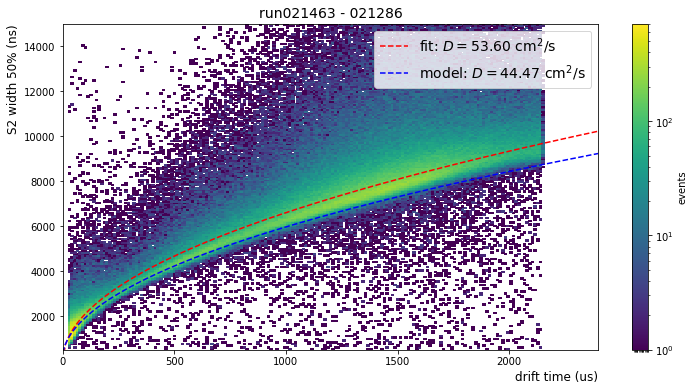

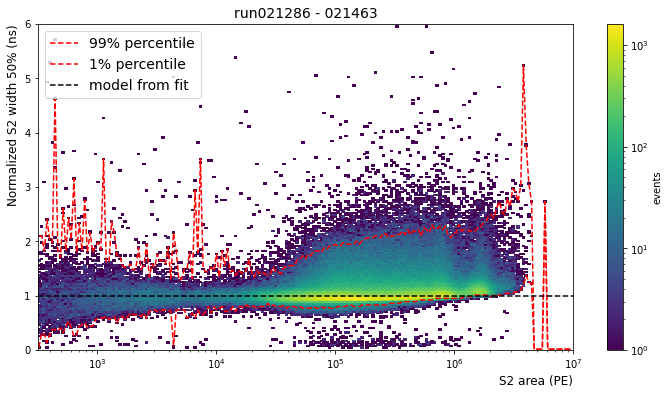

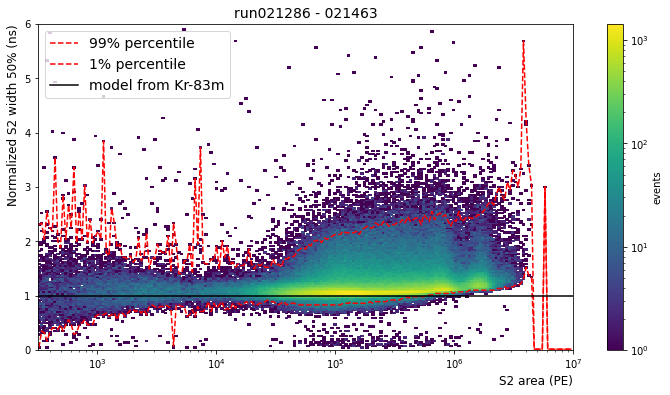

In [104]:
S2WidthCut_percentile(AmBe_events, AmBe_runs, mod_par = (44.47, 0.676, 375), lim_rad = 70)

Loading event_info: |          | 0.00 % [00:00<?]

run 021455, start 2021-06-05 01:17:20.334631, livetime 1799.01 s, rate: 1.02 Hz, selection rate: 0.05 Hz
events before selection 12864 events after selection 89


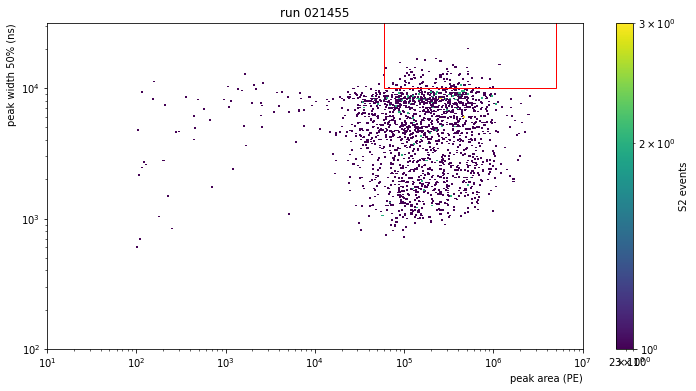

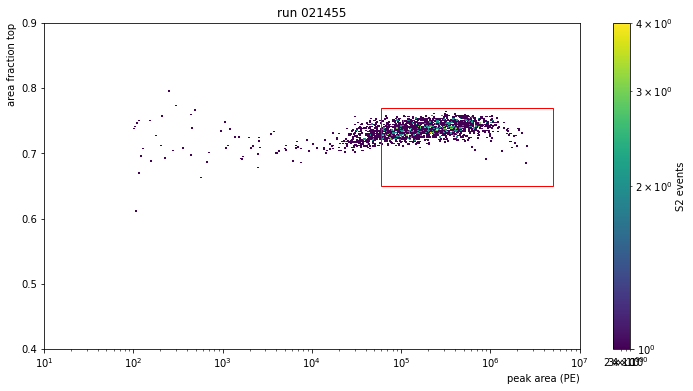

In [292]:
import bokeh.plotting as bklt
from IPython.core.display import display, HTML
#from bokeh.io import export_png
display(HTML("<style>.container { width:70% !important; }</style>"))

run_id = AmBe_runs[4]
st.is_stored(run_id, ('events','event_basics'))
ev0 = st.get_array(run_id, 'event_info')
ev1 = ev0[basic_cuts(ev0)]
mask_awt = ddu.mask_s2_area_width_aft(ev1,run_id,area_cut=(6e4,5e6),width_cut=(1e4,1e6),high=7,aft_cut=(0.65,0.77),plot=1)
events = ev1[mask_awt[0]]
print('events before selection',len(ev0),'events after selection',len(events))

In [295]:
for i in range(10):
    idx = int(np.random.rand()*len(events))
    fig = st.event_display_interactive(run_id,
                                       time_range=(events[idx]['time'],events[idx]['endtime']),
                                       bottom_pmt_array=False)
    bklt.show(fig)
    #straxen.bokeh_to_wiki(fig)
    #export_png(fig, filename="plot.png")

In [306]:
def plot_r2_z(ev, runs):
    r2 = ev['x']*ev['x'] + ev['y']*ev['y']
    ph_r2z = Histdd(r2, ev['z'],bins=(np.linspace(0, 6300, 200), np.linspace(-150, 1, 200)))
    ph_xy = Histdd(ev['x'], ev['y'],bins=(np.linspace(-75, 75, 200), np.linspace(-75, 75, 200)))
    plt.figure(figsize=(12,6))
    ph_r2z.plot(log_scale=True,cblabel='events')
    plt.xlabel(r"r^2 (cm^2)", ha='right', x=1)
    plt.ylabel("z (cm)", ha='right', y=1)
    plt.title(f'run{runs[-1]} - {runs[0]}',fontsize=14)
    plt.figure(figsize=(10,8))
    ph_xy.plot(log_scale=True,cblabel='events')
    plt.xlabel("x (cm)", ha='right', x=1)
    plt.ylabel("y (cm)", ha='right', y=1)
    plt.title(f'run{runs[-1]} - {runs[0]}',fontsize=14)

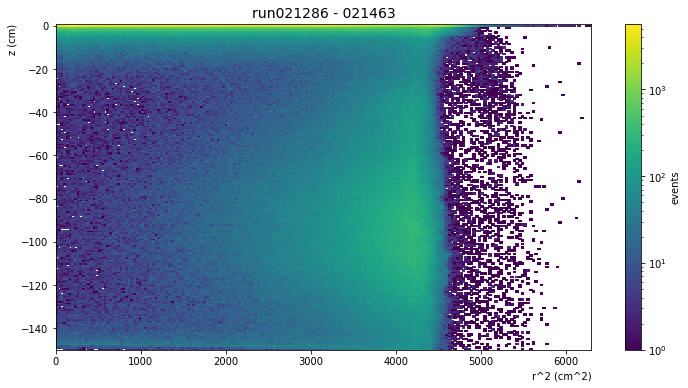

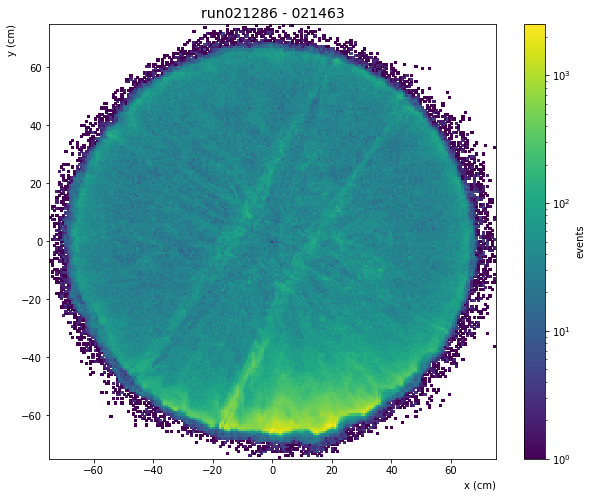

In [307]:
plot_r2_z(AmBe_events,AmBe_runs)

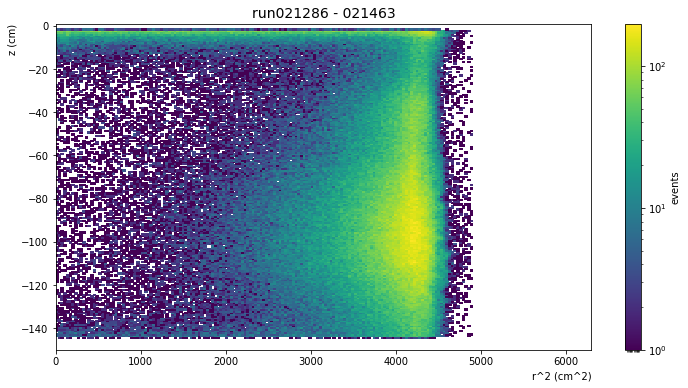

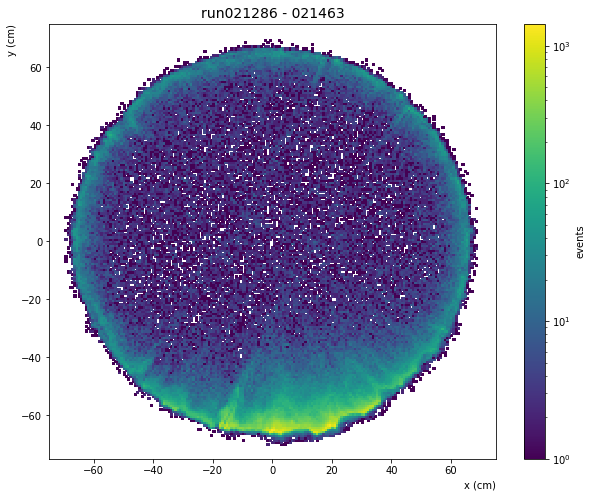

In [310]:
plot_r2_z(AmBe_events[basic_cuts(AmBe_events)],AmBe_runs)

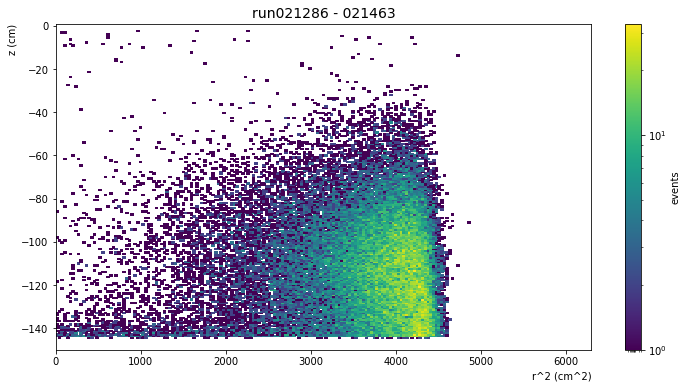

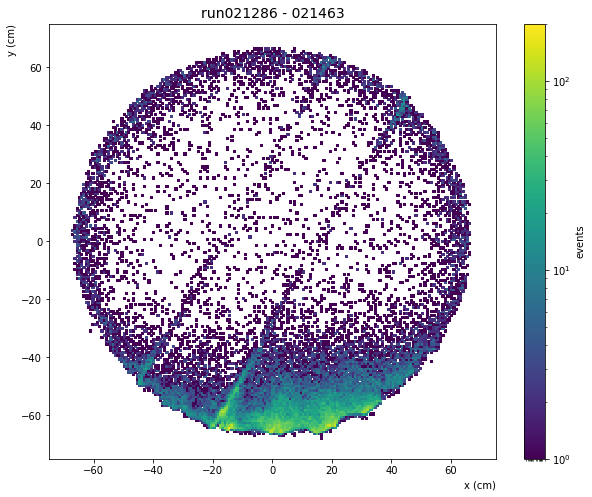

In [317]:
evv = AmBe_events[(basic_cuts(AmBe_events)) & (AmBe_events['s2_area']>5e4)
                 & (AmBe_events['s2_range_50p_area']>1e4)]
plot_r2_z(evv,AmBe_runs)